In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# EDA

### Read the data

In [2]:
df = pd.read_csv("train.csv")

`Dictionary:`

* site_id - ID code for the source hospital.
* patient_id - ID code for the patient.
* image_id - ID code for the image.
* laterality - Whether the image is of the left or right breast.
* view - The orientation of the image. The default for a screening exam is to capture two views per breast.
* age - The patient's age in years.
* cancer - Whether or not the breast was positive for malignant cancer. The target value. Only provided for train.
* biopsy - Whether or not a follow-up biopsy was performed on the breast. Only provided for train.
* invasive - If the breast is positive for cancer, whether or not the cancer proved to be invasive. Only provided for train.
* BIRADS - 0 if the breast required follow-up, 1 if the breast was rated as negative for cancer, and 2 if the breast was rated as normal. Only provided for train.
* implant - Whether or not the patient had breast implants. Site 1 only provides breast implant information at the patient level, not at the breast level.
* density - A rating for how dense the breast tissue is, with A being the least dense and D being the most dense. Extremely dense tissue can make diagnosis more difficult. Only provided for train.
* machine_id - An ID code for the imaging device.
* difficult_negative_case - True if the case was unusually difficult. Only provided for train.

In [3]:
df.sample(10)

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
51626,1,666,1188316397,R,CC,59.0,0,0,0,NaN,0,C,49,False
26905,1,38750,417875449,L,MLO,60.0,0,0,0,NaN,0,B,49,False
11541,1,22376,602776950,R,MLO,72.0,0,0,0,NaN,0,A,49,False
1107,1,11158,782151233,L,MLO,55.0,0,0,0,1.0,1,C,49,False
10437,2,21246,2016025748,L,CC,65.0,0,0,0,NaN,0,NaN,48,False
43836,1,57280,1571132579,L,CC,53.0,0,0,0,1.0,0,C,49,False
9058,1,19698,1584706398,L,CC,57.0,0,0,0,1.0,0,B,49,False
13266,2,24237,1389203581,R,CC,65.0,0,0,0,NaN,0,NaN,48,False
51841,2,6928,1721944221,R,MLO,64.0,0,0,0,NaN,0,NaN,29,False
26005,1,3780,1090626001,R,MLO,57.0,0,0,0,NaN,0,B,49,False


### Dtypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   site_id                  54706 non-null  int64  
 1   patient_id               54706 non-null  int64  
 2   image_id                 54706 non-null  int64  
 3   laterality               54706 non-null  object 
 4   view                     54706 non-null  object 
 5   age                      54669 non-null  float64
 6   cancer                   54706 non-null  int64  
 7   biopsy                   54706 non-null  int64  
 8   invasive                 54706 non-null  int64  
 9   BIRADS                   26286 non-null  float64
 10  implant                  54706 non-null  int64  
 11  density                  29470 non-null  object 
 12  machine_id               54706 non-null  int64  
 13  difficult_negative_case  54706 non-null  bool   
dtypes: bool(1), float64(2)

### Share of NaN values in each column

In [5]:
df.isna().mean(axis=0)

site_id                    0.000000
patient_id                 0.000000
image_id                   0.000000
laterality                 0.000000
view                       0.000000
age                        0.000676
cancer                     0.000000
biopsy                     0.000000
invasive                   0.000000
BIRADS                     0.519504
implant                    0.000000
density                    0.461302
machine_id                 0.000000
difficult_negative_case    0.000000
dtype: float64

`BIRADS` and `density` have many NaN values, so we discard them, `age` has few NaN values, so we discard rows without the value.

`biopsy` shows whether a biopsy was performed or not and `invasive` shows the type for those who had a biopsy. And we do not know on what basis the decision to perform the biopsy was made. Therefore, it seems that we should drop these features from the baseline model

### Train test split

In [6]:
X = df[["age", "implant", "cancer"]]
X = X[X["age"].notna()]
y = X.cancer
X = X.drop("cancer", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Target variable distribution

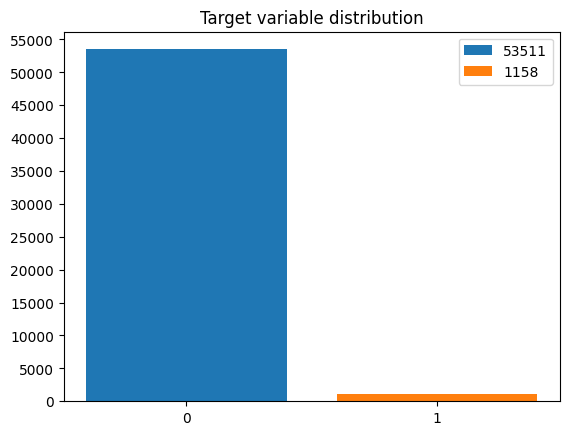

In [7]:
distribution = y.value_counts()

plt.bar(0, distribution[0], label=f"{distribution[0]}")
plt.bar(1, distribution[1], label=f"{distribution[1]}")
plt.title("Target variable distribution")
plt.xticks([0, 1])
plt.yticks(np.arange(0, 55_000 + 1, 5000))
plt.legend()
plt.show()

### Feature distributions

#### Age

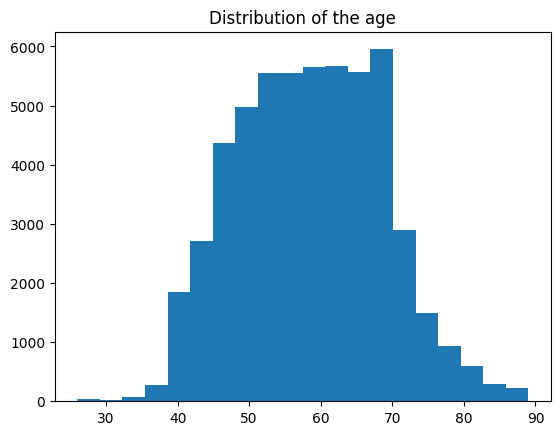

In [8]:
bins = 20

plt.figure()
plt.hist(X.age, bins=bins)
plt.title(f"Distribution of the age")
plt.show()

#### Age, cancer = 1

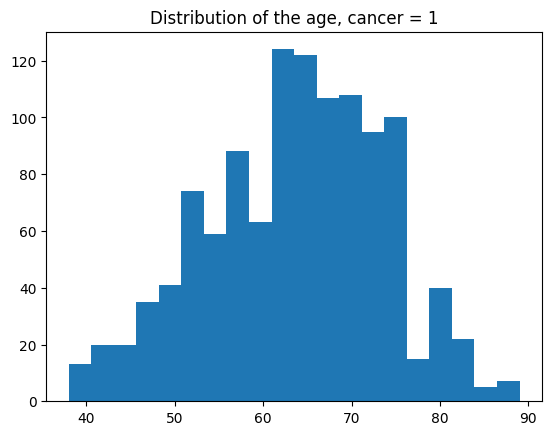

In [9]:
plt.figure()
plt.hist(X.loc[y[y == 1].index, :].age, bins=bins)
plt.title(f"Distribution of the age, cancer = 1")
plt.show()

#### implant

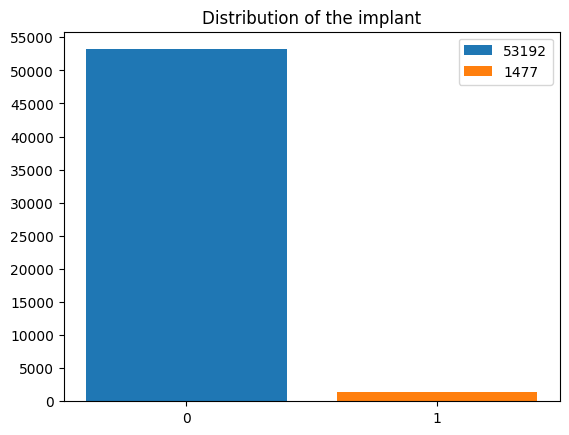

In [10]:
distribution = X.implant.value_counts()

plt.bar(0, distribution[0], label=f"{distribution[0]}")
plt.bar(1, distribution[1], label=f"{distribution[1]}")
plt.title(f"Distribution of the implant")
plt.xticks([0, 1])
plt.yticks(np.arange(0, 55_000 + 1, 5000))
plt.legend()
plt.show()

#### implant, cancer = 1

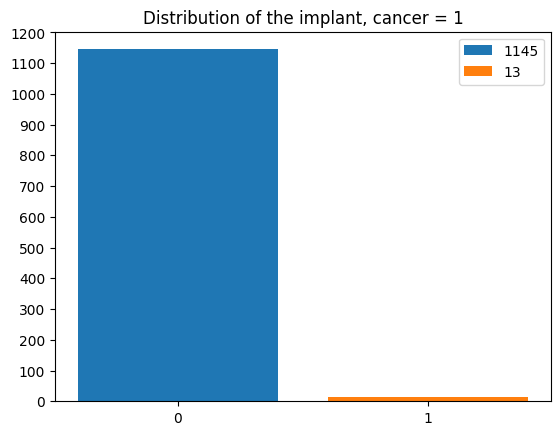

In [11]:
distribution = X.loc[y[y == 1].index, :].implant.value_counts()

plt.bar(0, distribution[0], label=f"{distribution[0]}")
plt.bar(1, distribution[1], label=f"{distribution[1]}")
plt.title(f"Distribution of the implant, cancer = 1")
plt.xticks([0, 1])
plt.yticks(np.arange(0, 1_200 + 1, 100))
plt.legend()
plt.show()

### Type 1 model

In [12]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

print(classification_report(y_test, y_pred_dummy, zero_division=0))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     16054
           1       0.00      0.00      0.00       347

    accuracy                           0.98     16401
   macro avg       0.49      0.50      0.49     16401
weighted avg       0.96      0.98      0.97     16401



`Comment:` The vast majority of patients do not have cancer, so we see very high accuracy of the model, while it did not predict any patients with cancer. Accuracy is not a relevant metric for this problem. The most important metric for us is the recall for the target class

### Type 2 model

best params: {'max_depth': 4, 'min_samples_split': 10}
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     16054
           1       0.04      0.47      0.07       347

    accuracy                           0.73     16401
   macro avg       0.51      0.60      0.46     16401
weighted avg       0.96      0.73      0.83     16401



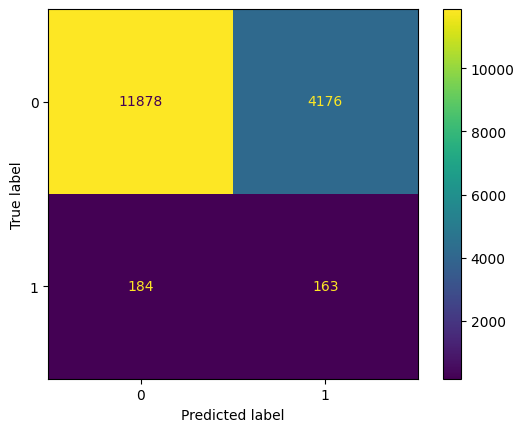

In [13]:
clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)

random_forest_grid = {
    "max_depth": [2, 3, 4, 5, 6],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
}

clf_cv = HalvingGridSearchCV(
    estimator=clf,
    param_grid=random_forest_grid,
    cv=5,
    random_state=42,
    n_jobs=-1,
)

clf_cv.fit(X_train, y_train)

threshold = 0.024
y_pred = clf_cv.predict_proba(X_test)[:, 1] > threshold

print(f"best params: {clf_cv.best_params_}")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

`Comment:` Since we chose recall as the target metric, the threshold has been changed. We do not have good enough data, the model does not show meaningful results. In the future we will change the baseline model and use the images to develop the model